In [3]:
%matplotlib inline
from fgspectra import cross as fgc
from fgspectra import power as fgp
from fgspectra import frequency as fgf
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import sensitivity_calculator as sens
from scipy.optimize import minimize
import sys
sys.path.append('/root/')
import pcl_actpol_utility_v4 as pau
import emcee
import corner

def get_hivon_fsky(mask):
    npix = len(mask)
    non0 = np.where(mask!=0)[0]
    fs = len(non0)/float(npix)
    w2 = np.sum(mask[non0]**2)/(npix*fs)
    w4 = np.sum(mask[non0]**4)/(npix*fs)
    return fs*w2**2/w4


#range for power spectra
ells = np.arange(2, 8000)

#parameters for fgspectra
par = {
    "nu_0": 150.0,
    "ell_0": 3000,
    "T_CMB": 2.725,
    "T_d": 9.7,
    "a_tSZ": 4.66,
    "a_kSZ": 1.60,
    "a_p": 6.87,
    "beta_p": 2.08,
    "a_c": 6.10,
    "beta_c": 2.08,
    "n_CIBC": 1.20,
    "xi": 0.09,
    "a_s": 3.50,
    "a_g": 0.88,
}
# define the models from fgspectra
ksz = fgc.FactorizedCrossSpectrum(fgf.ConstantSED(), fgp.kSZ_bat())
cibp = fgc.FactorizedCrossSpectrum(fgf.ModifiedBlackBody(), fgp.PowerLaw())
radio = fgc.FactorizedCrossSpectrum(fgf.PowerLaw(), fgp.PowerLaw())
cirrus = fgc.FactorizedCrossSpectrum(fgf.PowerLaw(), fgp.PowerLaw())

# if there are correlations between components,
# have to define them in a joined spectrum
tSZ_and_CIB = fgc.CorrelatedFactorizedCrossSpectrum(
    fgf.Join(fgf.ThermalSZ(), fgf.CIB()), fgp.SZxCIB_Addison2012()
)

# for testing purposes we'll also compute the tSZ and clustered CIB alone
tsz = fgc.FactorizedCrossSpectrum(fgf.ThermalSZ(), fgp.tSZ_150_bat())
cibc = fgc.FactorizedCrossSpectrum(fgf.CIB(), fgp.PowerLaw())
def get_fg_model(freqs, ells, par):
    return (
        par["a_kSZ"] * ksz({"nu": freqs}, {"ell": ells, "ell_0": par["ell_0"]}),
        par["a_p"]
        * cibp(
            {
                "nu": freqs,
                "nu_0": par["nu_0"],
                "temp": par["T_d"],
                "beta": par["beta_p"],
            },
            {"ell": ells, "ell_0": par["ell_0"], "alpha": 2},
        ),
        # joint tSZ, CIB, and their correlation
        tSZ_and_CIB(
            {
                "kwseq": (
                    {"nu": freqs, "nu_0": par["nu_0"]},
                    {
                        "nu": freqs,
                        "nu_0": par["nu_0"],
                        "temp": par["T_d"],
                        "beta": par["beta_c"],
                    },
                )
            },
            {
                "kwseq": (
                    {"ell": ells, "ell_0": par["ell_0"], "amp": par["a_tSZ"]},
                    {
                        "ell": ells,
                        "ell_0": par["ell_0"],
                        "alpha": 2 - par["n_CIBC"],
                        "amp": par["a_c"],
                    },
                    {
                        "ell": ells,
                        "ell_0": par["ell_0"],
                        "amp": -par["xi"] * np.sqrt(par["a_tSZ"] * par["a_c"]),
                    },
                )
            },
        ),
        par["a_s"]
        * radio(
            {"nu": freqs, "nu_0": par["nu_0"], "beta": -0.5 - 2},
            {"ell": ells, "ell_0": par["ell_0"], "alpha": 2},
        ),
        par["a_g"]
        * cirrus(
            {"nu": freqs, "nu_0": par["nu_0"], "beta": 3.8 - 2},
            {"ell": ells, "ell_0": par["ell_0"], "alpha": -0.7},
        ),
        # THESE TWO ARE REDUDUNDANT, BUT USEFUL FOR TESTING
        par["a_tSZ"]
        * tsz({"nu": freqs, "nu_0": par["nu_0"]}, {"ell": ells, "ell_0": par["ell_0"]}),
        par["a_c"]
        * cibc(
            {
                "nu": freqs,
                "nu_0": par["nu_0"],
                "temp": par["T_d"],
                "beta": par["beta_c"],
            },
            {"ell": ells, "ell_0": par["ell_0"], "alpha": 2 - par["n_CIBC"]},
        ),
    )

#(env)$ python3 -m ipykernel install --user --name=env


###############################################################################################333
#use sensitivity calculator 
inputs = {'diameter': 5.7, 't': 273, 'wfe': 10.7, 'eta': 0.98, 'doe': 0.8, 't_int': 1, 'pixelYield': 0.8, 
        'szCamNumPoln': 1, 'eorSpecNumPoln': 2, 't_filter_cold': np.array([0.593, 0.84 , 0.86, 0.86, 0.89 ]), 
        't_lens_cold': np.array([0.98, 0.98, 0.98, 0.98, 0.98]), 
        't_uhdpe_window': np.array([0.96, 0.97, 0.97, 0.97, 0.97]), 
        'singleModedAOmegaLambda2': np.array([1., 1., 1., 1., 1.]), 
        'spatialPixels': np.array([39762, 20808, 10368, 10368,  7938]), 
        'eqbw': np.array([9.7e+10, 3.0e+10, 3.5e+10, 6.0e+10, 5.6e+10]), 
        'centerFrequency': np.array([8.50e+11, 4.05e+11, 3.48e+11, 2.80e+11, 2.22e+11]), 'detectorNEP': 0, 
        'backgroundSubtractionDegradationFactor': 1, 'r': np.array([[100., 100., 100.],
                                            [100., 100., 100.],
                                            [100., 100., 100.],
                                            [100., 100., 100.],
                                            [100., 100., 100.]]), 
        'decimalPlaces': 3, 'observationElevationAngle': 45, 'outputFreq': True, 
        'detectorSpacing': np.array([1.45, 1.97, 2.75, 2.75, 3.13]), 'lyotStopAngle': 13.4}
# Alternatively, sens.getInputs("input.yaml")

#spillEfficiency = sens.getSpillEfficiency(inputs, oldFile=False)
#print(spillEfficiency)
spillEfficiency = sens.getSpillEfficiency(inputs, oldFile=True)
#print(spillEfficiency)
# spillEfficienc#y = np.array([0.8,0.5,0.7,0.95,0.5])
calculate = sens.calcByAngle(inputs["diameter"], inputs["t"], inputs["wfe"], inputs["eta"], inputs["doe"], inputs["t_int"], inputs["pixelYield"], inputs["szCamNumPoln"], inputs["eorSpecNumPoln"],
                            inputs["t_filter_cold"], inputs["t_lens_cold"], inputs["t_uhdpe_window"], spillEfficiency, inputs["singleModedAOmegaLambda2"],
                            inputs["spatialPixels"], inputs["eqbw"], inputs["centerFrequency"], inputs["detectorNEP"],
                            inputs["backgroundSubtractionDegradationFactor"], inputs["r"])
outputs = calculate(45) #45 degree angle

#get noise from sens, by l, temp noise, and pol noise
ell, N_ell_T_full, N_ell_P_full = sens.getNoiseCurves(inputs, outputs)
dl = ell*(ell+1)/(2*np.pi)

#get sky fraction fsky
NSIDE = 1024
hitmap_path = "~/mask_share/ccat_uniform_coverage_nside" + str(NSIDE) + "_201021.fits"
mask_path = "~/mask_share/nside" + str(NSIDE) + "_lat_cut_b10_230619.fits"
hitm = hp.read_map(hitmap_path)
maskm = hp.read_map(mask_path)
#hp.mollview(hitm*maskm)
#hp.mollview(maskm)
fsky = np.sum(hitm*maskm)/len(hitm)
fsky = get_hivon_fsky(hitm*maskm)
#print('fsky=%.4f'%fsky)

#binning
lmax_cut = 8000
binfile = '/root/BIN_ACTPOL_50_4_SC_low_ell'
lbands = pau.read_binfile(binfile, lcut=lmax_cut)
(ell_bin, band, nbins, lmax, elxx, dxx) = pau.get_lbands_all(lbands)
'''
def get_lbands_all(lbands):
   nbins = len(lbands)
   lmax = lbands[-1, -1]
   ell = np.arange(lmax + 1)
   dl = ell*(ell+1)/(2*np.pi)

   band = np.zeros(nbins)
   ell_bin = np.zeros(nbins)

   for i in range(nbins):
      band[i] = (lbands[i,1]-lbands[i,0])/2.
      ell_bin[i] = (lbands[i,0]+lbands[i,1])/2.

   return (ell_bin, band, nbins, lmax, ell, dl)
def get_analytic_var_auto(fsky, ell_bin, lband_width):
   """ compute total variance for auto spectra:
       get sig(C_l) from C_l (Knox 1995)
       watch the lband_width input which is half the actual width
   """
   return np.sqrt(2.0 / ((2.0 * ell_bin + 1.0) * fsky * (lband_width * 2 + 1)))

#eq 2.5 in steve paper https://arxiv.org/pdf/1509.05934
def get_analytic_var_cross(fsky, ell_bin, lband_width):
   """ compute total variance for cross spectra:
       get sig(C_l) from C_l (Knox 1995)
       watch the lband_width input which is half the actual width
   """
   return np.sqrt(2.0 / ((2.0 * ell_bin + 1.0) * fsky * (lband_width * 2 + 1)))/np.sqrt(2)
'''
#g_fac = 1/sqrt(number of modes nu)
g_fac = pau.get_analytic_var_cross(fsky, ell_bin, band)

#frequency indices from sensitivity_calc
#[8.50e+11, 4.05e+11, 3.48e+11, 2.80e+11, 2.22e+11]
#    0          1        2         3         4

#frequency indices from sensitivity_calc
#[8.50e+11, 4.05e+11, 3.48e+11, 2.80e+11, 2.22e+11]
#    0          1        2         3         4
nl_280_bin = (N_ell_T_full[3]*dl)[np.array(ell_bin-1.5,'int')]
nl_350_bin = (N_ell_T_full[2]*dl)[np.array(ell_bin-1.5,'int')]
nl_850_bin = (N_ell_T_full[0]*dl)[np.array(ell_bin-1.5,'int')]



In [4]:
#actual centers for primecam
centerfreqs = np.array([280.0,350.0,850.0])

#generate spectra as seen by the center frequencies
centerspecs = get_fg_model(centerfreqs, ells, par)
#centerspecs[foreground index][center frequency index, center frequency index]
#spectra ['a_kSZ','a_p','tSZ_CIB','a_s','a_g','a_tSZ','a_c'] #spectra
#           0       1       2       3     4      5      6

#cib_850 = centerspecs[1][2,2]+centerspecs[6][2,2]
#cib_850_bin = cib_850[np.array(ell_bin-1.5,'int')]

#assign bins a la:
#cib_280_bin = centerspecs[6][0,0][np.array(ell_bin-1.5,'int')]

spectra_bin = np.zeros((3, 7), dtype=object)
sig = []
#iterate over 3 frequencies
for f in range(3):
    sig.append(np.sum([s[f, f] for s in centerspecs], axis=0)[np.array(ell_bin-1.5,'int')])
    #iterate over 7 spectra, get bins, put in array
    for s, spectrum in enumerate(centerspecs):
        spectra_bin[f][s] = centerspecs[s][f,f][np.array(ell_bin-1.5,'int')]
    
sig = np.array(sig)

err = np.zeros((3, 7), dtype=object)
tot_err = np.zeros((3, 7), dtype=object)

for s, spectrum in enumerate(centerspecs):

    err[0][s] = np.sqrt(2)*g_fac*(spectra_bin[0][s]+nl_280_bin)
    err[1][s] = np.sqrt(2)*g_fac*(spectra_bin[1][s]+nl_350_bin)
    err[2][s] = np.sqrt(2)*g_fac*(spectra_bin[2][s]+nl_850_bin)

    tot_err[0][s] = np.sqrt(2)*g_fac*(sig[0]+nl_280_bin)
    tot_err[1][s] = np.sqrt(2)*g_fac*(sig[1]+nl_350_bin)
    tot_err[2][s] = np.sqrt(2)*g_fac*(sig[2]+nl_850_bin)

280 only


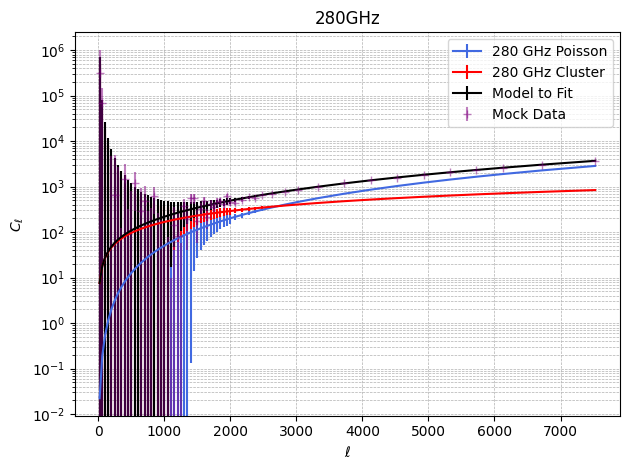

100%|██████████| 5000/5000 [00:05<00:00, 973.42it/s]


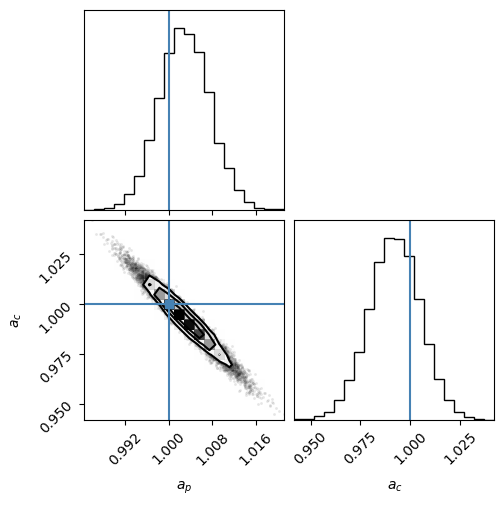

a_p: 1.003 ± 0.005
a_c: 0.992 ± 0.013


In [5]:
##################################################################################################################################3
#fitting begins here
print("280 only")
#for 280 only
#
T_p = spectra_bin[0][1]  
T_c = spectra_bin[0][6]  
err_p = err[0][1]
err_c = err[0][6]

a_p_true = 1.0
a_c_true = 1.0

y_err = np.sqrt(err_p**2 + err_c**2)
model = a_p_true * T_p + a_c_true * T_c
data = np.random.normal(model, y_err)

plt.errorbar(ell_bin, T_p, yerr=err_p, fmt='-', color='RoyalBlue', label='280 GHz Poisson')
plt.errorbar(ell_bin, T_c, yerr=err_c, fmt='-', color='Red', label='280 GHz Cluster')
plt.errorbar(ell_bin, model, yerr=y_err, fmt='-', color='black', label='Model to Fit')
plt.errorbar(ell_bin, data, yerr=y_err, fmt='+', color='purple', alpha=0.5, label='Mock Data')

plt.legend()
plt.yscale('log')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_\ell$')
plt.title('280GHz')
plt.grid(True, which='both', ls='--', lw=0.5)
plt.tight_layout()
plt.show()

def log_likelihood(theta, T_p, T_c, data, y_err):
    a_p, a_c = theta
    model = a_p * T_p + a_c * T_c
    sigma2 = y_err**2
    return -0.5 * np.sum((data - model)**2 / sigma2 + np.log(sigma2))

#flat prior function
def log_prior(theta):
    a_p, a_c = theta
    if 0.0 < a_p < 5.0 and 0.0 < a_c < 5.0:
        return 0.0
    return -np.inf

def log_probability(theta, T_p, T_c, data, y_err):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, T_p, T_c, data, y_err)

np.random.seed(42)
ndim = 2
nwalkers = 32
initial = np.array([a_p_true, a_c_true]) + 0.01 * np.random.randn(nwalkers, ndim)

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(T_p, T_c, data, y_err)
)
sampler.run_mcmc(initial, 5000, progress=True)

samples = sampler.get_chain(discard=1000, thin=10, flat=True)
fig = corner.corner(samples, labels=["$a_p$", "$a_c$"], truths=[a_p_true, a_c_true])
plt.show()


a_p_samples = samples[:, 0]
a_c_samples = samples[:, 1]

###
#corr = np.corrcoef(a_p_samples, a_c_samples)[0, 1]
#print(f"Correlation coefficient: {corr:.3f}")
print(f"a_p: {np.mean(a_p_samples):.3f} ± {np.std(a_p_samples):.3f}")
print(f"a_c: {np.mean(a_c_samples):.3f} ± {np.std(a_c_samples):.3f}")

You must install the tqdm library to use progress indicators with emcee


280+350 Uncorrelated
280+350 Uncorrelated


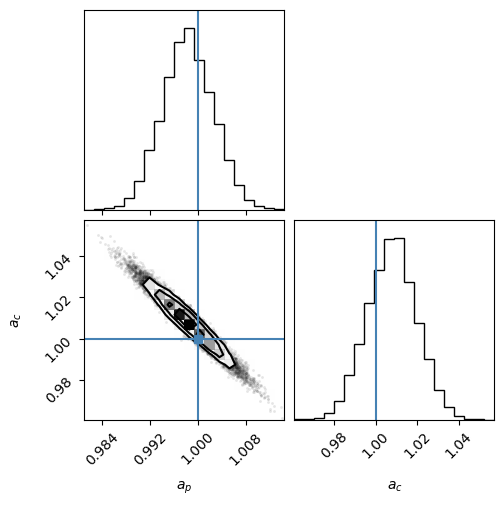

Correlation coefficient: -0.976
a_p: 0.998 ± 0.004
a_c: 1.008 ± 0.012


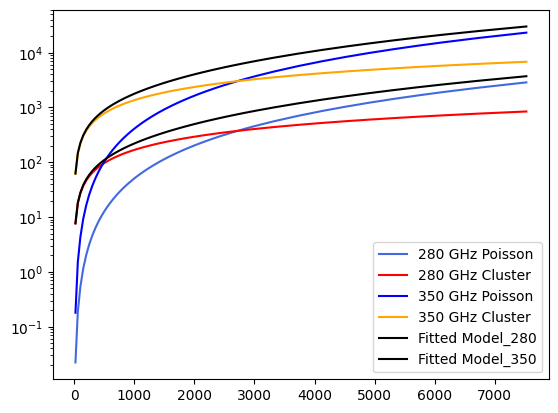

In [4]:
#280+350 uncorrelated
print("280+350 Uncorrelated")
# Templates
T_p_280 = spectra_bin[0][1]
T_c_280 = spectra_bin[0][6]
T_p_350 = spectra_bin[1][1]
T_c_350 = spectra_bin[1][6]


# True parameters for mock data
a_p_true = 1.0
a_c_true = 1.0

# Data generation (mock)
y_err_280 = np.sqrt(err[0][1]**2 + err[0][6]**2)
y_err_350 = np.sqrt(err[1][1]**2 + err[1][6]**2)

data_280 = np.random.normal(a_p_true * T_p_280 + a_c_true * T_c_280, y_err_280)
data_350 = np.random.normal(a_p_true * T_p_350 + a_c_true * T_c_350, y_err_350)

# Stack templates and data
data = np.concatenate([data_280, data_350])
y_err = np.concatenate([y_err_280, y_err_350])
T_p = np.concatenate([T_p_280, T_p_350])
T_c = np.concatenate([T_c_280, T_c_350])

# Log-likelihood and prior
def log_likelihood(theta, T_p, T_c, data, y_err):
    a_p, a_c = theta
    model = a_p * T_p + a_c * T_c
    sigma2 = y_err**2
    return -0.5 * np.sum((data - model)**2 / sigma2 + np.log(sigma2))

def log_prior(theta):
    a_p, a_c = theta
    if 0.0 < a_p < 5.0 and 0.0 < a_c < 5.0:
        return 0.0
    return -np.inf

def log_probability(theta, T_p, T_c, data, y_err):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, T_p, T_c, data, y_err)

# Run MCMC
np.random.seed(42)
ndim = 2
nwalkers = 32
initial = np.array([a_p_true, a_c_true]) + 0.01 * np.random.randn(nwalkers, ndim)

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(T_p, T_c, data, y_err)
)
sampler.run_mcmc(initial, 5000, progress=True)

print("280+350 Uncorrelated")
# Corner plot
samples = sampler.get_chain(discard=1000, thin=10, flat=True)
fig = corner.corner(samples, labels=["$a_p$", "$a_c$"], truths=[a_p_true, a_c_true])
plt.show()

# Best-fit + correlation
a_p_samples = samples[:, 0]
a_c_samples = samples[:, 1]
corr = np.corrcoef(a_p_samples, a_c_samples)[0, 1]
print(f"Correlation coefficient: {corr:.3f}")
print(f"a_p: {np.mean(a_p_samples):.3f} ± {np.std(a_p_samples):.3f}")
print(f"a_c: {np.mean(a_c_samples):.3f} ± {np.std(a_c_samples):.3f}")

model_280 = np.mean(a_p_samples) * T_p_280 + np.mean(a_c_samples) * T_c_280
model_350 = np.mean(a_p_samples) * T_p_350 + np.mean(a_c_samples) * T_c_350
plt.plot(ell_bin,T_p_280,label='280 GHz Poisson',color='RoyalBlue')
plt.plot(ell_bin,T_c_280,label='280 GHz Cluster',color='Red')
plt.plot(ell_bin,T_p_350,label='350 GHz Poisson',color='Blue')
plt.plot(ell_bin,T_c_350,label='350 GHz Cluster',color='Orange')
plt.plot(ell_bin,model_280,label='Fitted Model_280',color='black')
plt.plot(ell_bin,model_350,label='Fitted Model_350',color='black')
plt.legend()
plt.yscale('log')
plt.show()

You must install the tqdm library to use progress indicators with emcee


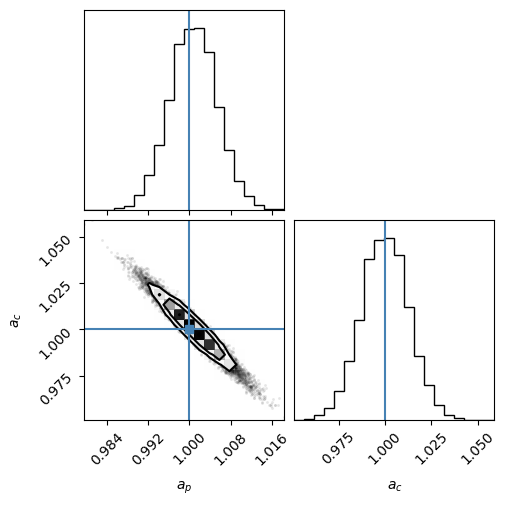

Correlation coefficient: -0.975
a_p: 1.001 ± 0.005
a_c: 1.000 ± 0.013


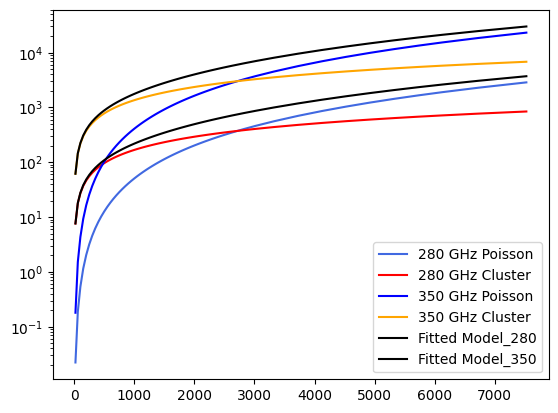

In [5]:
#280+350 correlated
# Templates
T_p_280 = spectra_bin[0][1]
T_c_280 = spectra_bin[0][6]
T_p_350 = spectra_bin[1][1]
T_c_350 = spectra_bin[1][6]

# True parameters
a_p_true = 1.0
a_c_true = 1.0

# Data generation
y_err_280 = np.sqrt(err[0][1]**2 + err[0][6]**2)
y_err_350 = np.sqrt(err[1][1]**2 + err[1][6]**2)

data_280 = np.random.normal(a_p_true * T_p_280 + a_c_true * T_c_280, y_err_280)
data_350 = np.random.normal(a_p_true * T_p_350 + a_c_true * T_c_350, y_err_350)

# Stack templates and data
data = np.concatenate([data_280, data_350])
y_err = np.concatenate([y_err_280, y_err_350])
T_p = np.concatenate([T_p_280, T_p_350])
T_c = np.concatenate([T_c_280, T_c_350])


n = len(y_err_280)  # number of ell bins
cov = np.zeros((2*n, 2*n))

#main diagonal
cov[:n, :n] = np.diag(y_err_280**2)
cov[n:, n:] = np.diag(y_err_350**2)

# Off-diagonal submatrices with diagonal blocks (correlation across frequencies at same ell-bin)
#arbitrary correlation coefficient
corr_coeff = 0.5

cross_cov = np.diag(corr_coeff * y_err_280 * y_err_350)
cov[:n, n:] = cross_cov
cov[n:, :n] = cross_cov.T

# Inverse and log determinant
cov_inv = np.linalg.inv(cov)
log_det_cov = np.linalg.slogdet(cov)[1]


def log_likelihood(theta, T_p, T_c, data, cov_inv, log_det_cov):
    a_p, a_c = theta
    model = a_p * T_p + a_c * T_c
    resid = data - model
    return -0.5 * (resid @ cov_inv @ resid + log_det_cov)

def log_prior(theta):
    a_p, a_c = theta
    if -5.0 < a_p < 5.0 and -5.0 < a_c < 5.0:
        return 0.0
    return -np.inf

def log_probability(theta, T_p, T_c, data, cov_inv, log_det_cov):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, T_p, T_c, data, cov_inv, log_det_cov)


# Run MCMC
np.random.seed(42)
ndim = 2
nwalkers = 32
initial = np.array([a_p_true, a_c_true]) + 0.01 * np.random.randn(nwalkers, ndim)

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(T_p, T_c, data, cov_inv, log_det_cov)
)

sampler.run_mcmc(initial, 5000, progress=True)

# Corner plot
samples = sampler.get_chain(discard=1000, thin=10, flat=True)
fig = corner.corner(samples, labels=["$a_p$", "$a_c$"], truths=[a_p_true, a_c_true])
plt.show()

# Best-fit + correlation
a_p_samples = samples[:, 0]
a_c_samples = samples[:, 1]
corr = np.corrcoef(a_p_samples, a_c_samples)[0, 1]
print(f"Correlation coefficient: {corr:.3f}")
print(f"a_p: {np.mean(a_p_samples):.3f} ± {np.std(a_p_samples):.3f}")
print(f"a_c: {np.mean(a_c_samples):.3f} ± {np.std(a_c_samples):.3f}")

model_280 = np.mean(a_p_samples) * T_p_280 + np.mean(a_c_samples) * T_c_280
model_350 = np.mean(a_p_samples) * T_p_350 + np.mean(a_c_samples) * T_c_350
plt.plot(ell_bin,T_p_280,label='280 GHz Poisson',color='RoyalBlue')
plt.plot(ell_bin,T_c_280,label='280 GHz Cluster',color='Red')
plt.plot(ell_bin,T_p_350,label='350 GHz Poisson',color='Blue')
plt.plot(ell_bin,T_c_350,label='350 GHz Cluster',color='Orange')
plt.plot(ell_bin,model_280,label='Fitted Model_280',color='black')
plt.plot(ell_bin,model_350,label='Fitted Model_350',color='black')
plt.legend()
plt.yscale('log')
plt.show()

You must install the tqdm library to use progress indicators with emcee


280+350 correlated, p = 0.90


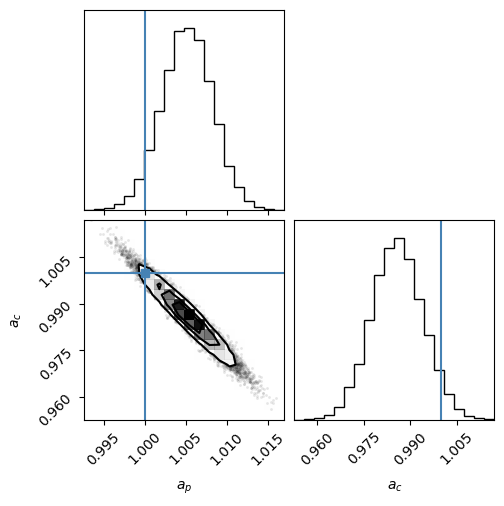

Correlation coefficient: -0.973
a_p: 1.005 ± 0.003
a_c: 0.986 ± 0.008


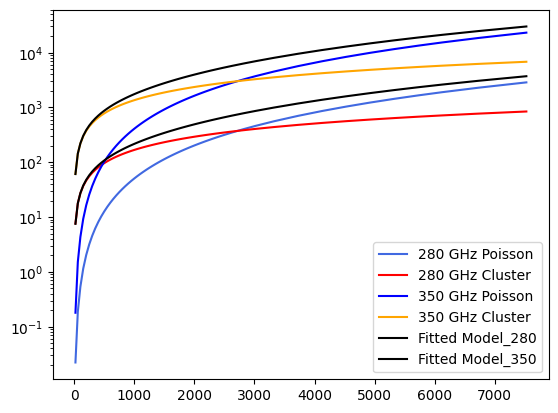

In [6]:
#280+350 correlated
print("280+350 correlated, p = 0.90")
# Templates
T_p_280 = spectra_bin[0][1]
T_c_280 = spectra_bin[0][6]
T_p_350 = spectra_bin[1][1]
T_c_350 = spectra_bin[1][6]

# True parameters
a_p_true = 1.0
a_c_true = 1.0

# Data generation
y_err_280 = np.sqrt(err[0][1]**2 + err[0][6]**2)
y_err_350 = np.sqrt(err[1][1]**2 + err[1][6]**2)

data_280 = np.random.normal(a_p_true * T_p_280 + a_c_true * T_c_280, y_err_280)
data_350 = np.random.normal(a_p_true * T_p_350 + a_c_true * T_c_350, y_err_350)

# Stack templates and data
data = np.concatenate([data_280, data_350])
y_err = np.concatenate([y_err_280, y_err_350])
T_p = np.concatenate([T_p_280, T_p_350])
T_c = np.concatenate([T_c_280, T_c_350])


n = len(y_err_280)  # number of ell bins
cov = np.zeros((2*n, 2*n))

#main diagonal
cov[:n, :n] = np.diag(y_err_280**2)
cov[n:, n:] = np.diag(y_err_350**2)

# Off-diagonal submatrices with diagonal blocks (correlation across frequencies at same ell-bin)
#arbitrary correlation coefficient
corr_coeff = 0.90

cross_cov = np.diag(corr_coeff * y_err_280 * y_err_350)
cov[:n, n:] = cross_cov
cov[n:, :n] = cross_cov.T

# Inverse and log determinant
cov_inv = np.linalg.inv(cov)
log_det_cov = np.linalg.slogdet(cov)[1]


def log_likelihood(theta, T_p, T_c, data, cov_inv, log_det_cov):
    a_p, a_c = theta
    model = a_p * T_p + a_c * T_c
    resid = data - model
    return -0.5 * (resid @ cov_inv @ resid + log_det_cov)

def log_prior(theta):
    a_p, a_c = theta
    if -5.0 < a_p < 5.0 and -5.0 < a_c < 5.0:
        return 0.0
    return -np.inf

def log_probability(theta, T_p, T_c, data, cov_inv, log_det_cov):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, T_p, T_c, data, cov_inv, log_det_cov)


# Run MCMC
np.random.seed(42)
ndim = 2
nwalkers = 32
initial = np.array([a_p_true, a_c_true]) + 0.01 * np.random.randn(nwalkers, ndim)

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(T_p, T_c, data, cov_inv, log_det_cov)
)

sampler.run_mcmc(initial, 5000, progress=True)

# Corner plot
samples = sampler.get_chain(discard=1000, thin=10, flat=True)
fig = corner.corner(samples, labels=["$a_p$", "$a_c$"], truths=[a_p_true, a_c_true])
plt.show()

# Best-fit + correlation
a_p_samples = samples[:, 0]
a_c_samples = samples[:, 1]
corr = np.corrcoef(a_p_samples, a_c_samples)[0, 1]
print(f"Correlation coefficient: {corr:.3f}")
print(f"a_p: {np.mean(a_p_samples):.3f} ± {np.std(a_p_samples):.3f}")
print(f"a_c: {np.mean(a_c_samples):.3f} ± {np.std(a_c_samples):.3f}")

model_280 = np.mean(a_p_samples) * T_p_280 + np.mean(a_c_samples) * T_c_280
model_350 = np.mean(a_p_samples) * T_p_350 + np.mean(a_c_samples) * T_c_350
plt.plot(ell_bin,T_p_280,label='280 GHz Poisson',color='RoyalBlue')
plt.plot(ell_bin,T_c_280,label='280 GHz Cluster',color='Red')
plt.plot(ell_bin,T_p_350,label='350 GHz Poisson',color='Blue')
plt.plot(ell_bin,T_c_350,label='350 GHz Cluster',color='Orange')
plt.plot(ell_bin,model_280,label='Fitted Model_280',color='black')
plt.plot(ell_bin,model_350,label='Fitted Model_350',color='black')
plt.legend()
plt.yscale('log')
plt.show()

You must install the tqdm library to use progress indicators with emcee


280+350 with p = 0.001 covariance


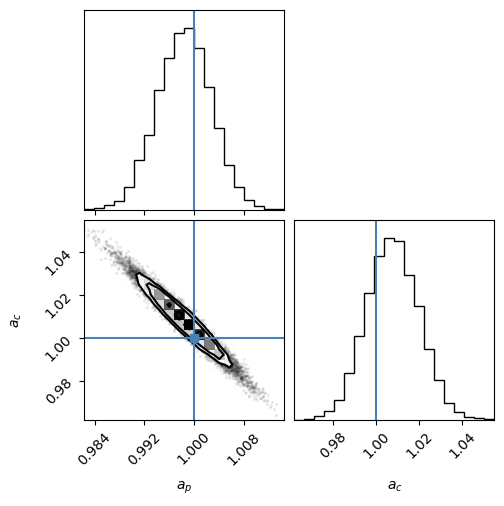

Correlation coefficient: -0.978
a_p: 0.998 ± 0.004
a_c: 1.008 ± 0.012


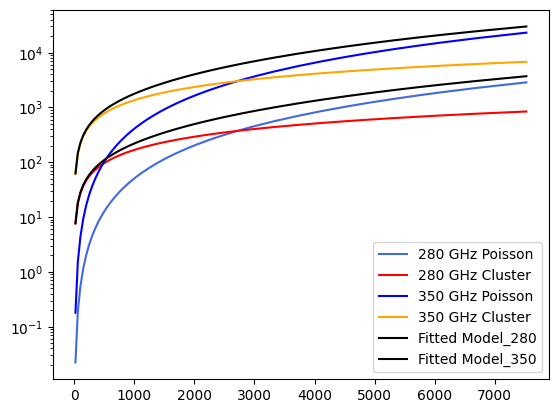

low corr_coeff


In [7]:
#280+350 correlated
# Templates
T_p_280 = spectra_bin[0][1]
T_c_280 = spectra_bin[0][6]
T_p_350 = spectra_bin[1][1]
T_c_350 = spectra_bin[1][6]

# True parameters
a_p_true = 1.0
a_c_true = 1.0

# Data generation
y_err_280 = np.sqrt(err[0][1]**2 + err[0][6]**2)
y_err_350 = np.sqrt(err[1][1]**2 + err[1][6]**2)

data_280 = np.random.normal(a_p_true * T_p_280 + a_c_true * T_c_280, y_err_280)
data_350 = np.random.normal(a_p_true * T_p_350 + a_c_true * T_c_350, y_err_350)

# Stack templates and data
data = np.concatenate([data_280, data_350])
y_err = np.concatenate([y_err_280, y_err_350])
T_p = np.concatenate([T_p_280, T_p_350])
T_c = np.concatenate([T_c_280, T_c_350])


n = len(y_err_280)  # number of ell bins
cov = np.zeros((2*n, 2*n))

#main diagonal
cov[:n, :n] = np.diag(y_err_280**2)
cov[n:, n:] = np.diag(y_err_350**2)

# Off-diagonal submatrices with diagonal blocks (correlation across frequencies at same ell-bin)
#arbitrary correlation coefficient
print("280+350 with p = 0.001 covariance")
corr_coeff = 0.001


cross_cov = np.diag(corr_coeff * y_err_280 * y_err_350)
cov[:n, n:] = cross_cov
cov[n:, :n] = cross_cov.T

# Inverse and log determinant
cov_inv = np.linalg.inv(cov)
log_det_cov = np.linalg.slogdet(cov)[1]


def log_likelihood(theta, T_p, T_c, data, cov_inv, log_det_cov):
    a_p, a_c = theta
    model = a_p * T_p + a_c * T_c
    resid = data - model
    return -0.5 * (resid @ cov_inv @ resid + log_det_cov)

def log_prior(theta):
    a_p, a_c = theta
    if -5.0 < a_p < 5.0 and -5.0 < a_c < 5.0:
        return 0.0
    return -np.inf

def log_probability(theta, T_p, T_c, data, cov_inv, log_det_cov):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, T_p, T_c, data, cov_inv, log_det_cov)


# Run MCMC
np.random.seed(42)
ndim = 2
nwalkers = 32
initial = np.array([a_p_true, a_c_true]) + 0.01 * np.random.randn(nwalkers, ndim)

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(T_p, T_c, data, cov_inv, log_det_cov)
)

sampler.run_mcmc(initial, 5000, progress=True)

# Corner plot
samples = sampler.get_chain(discard=1000, thin=10, flat=True)
fig = corner.corner(samples, labels=["$a_p$", "$a_c$"], truths=[a_p_true, a_c_true])
plt.show()

# Best-fit + correlation
a_p_samples = samples[:, 0]
a_c_samples = samples[:, 1]
corr = np.corrcoef(a_p_samples, a_c_samples)[0, 1]
print(f"Correlation coefficient: {corr:.3f}")
print(f"a_p: {np.mean(a_p_samples):.3f} ± {np.std(a_p_samples):.3f}")
print(f"a_c: {np.mean(a_c_samples):.3f} ± {np.std(a_c_samples):.3f}")

model_280 = np.mean(a_p_samples) * T_p_280 + np.mean(a_c_samples) * T_c_280
model_350 = np.mean(a_p_samples) * T_p_350 + np.mean(a_c_samples) * T_c_350
plt.plot(ell_bin,T_p_280,label='280 GHz Poisson',color='RoyalBlue')
plt.plot(ell_bin,T_c_280,label='280 GHz Cluster',color='Red')
plt.plot(ell_bin,T_p_350,label='350 GHz Poisson',color='Blue')
plt.plot(ell_bin,T_c_350,label='350 GHz Cluster',color='Orange')
plt.plot(ell_bin,model_280,label='Fitted Model_280',color='black')
plt.plot(ell_bin,model_350,label='Fitted Model_350',color='black')
plt.legend()
plt.yscale('log')
plt.show()
print('low corr_coeff')

280+350 cross covariance with p=0.5


You must install the tqdm library to use progress indicators with emcee


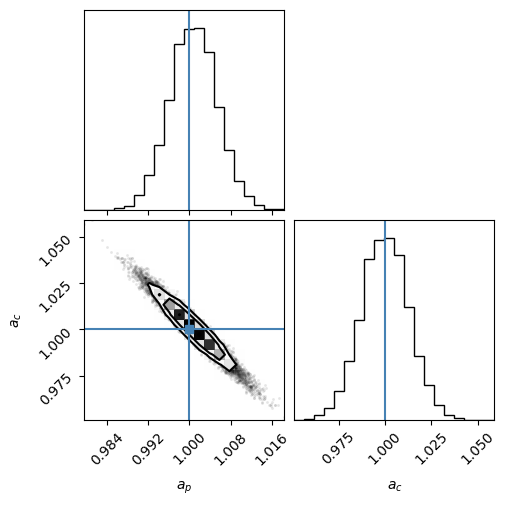

Correlation: -0.975
a_p: 1.001 ± 0.005
a_c: 1.000 ± 0.013


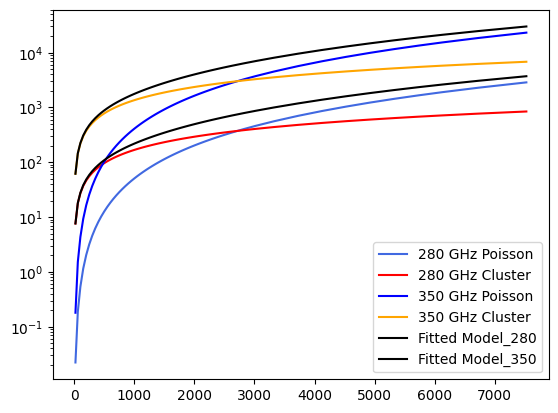

In [8]:
#280+350 correlated
# Templates
T_p_280 = spectra_bin[0][1]
T_c_280 = spectra_bin[0][6]
T_p_350 = spectra_bin[1][1]
T_c_350 = spectra_bin[1][6]

# True parameters
a_p_true = 1.0
a_c_true = 1.0

# Data generation
y_err_280 = np.sqrt(err[0][1]**2 + err[0][6]**2)
y_err_350 = np.sqrt(err[1][1]**2 + err[1][6]**2)

data_280 = np.random.normal(a_p_true * T_p_280 + a_c_true * T_c_280, y_err_280)
data_350 = np.random.normal(a_p_true * T_p_350 + a_c_true * T_c_350, y_err_350)

#print(np.mean(np.corrcoef(y_err_280, y_err_350)))

# Stack templates and data
data = np.concatenate([data_280, data_350])
y_err = np.concatenate([y_err_280, y_err_350])
T_p = np.concatenate([T_p_280, T_p_350])
T_c = np.concatenate([T_c_280, T_c_350])


n = len(y_err_280)  # number of ell bins
cov = np.zeros((2*n, 2*n))

#main diagonal
cov[:n, :n] = np.diag(y_err_280**2)
cov[n:, n:] = np.diag(y_err_350**2)

# Off-diagonal submatrices with diagonal blocks (correlation across frequencies at same ell-bin)
#arbitrary correlation coefficient
print("280+350 cross covariance with p=0.5")
corr_coeff = 0.5

cross_cov = np.diag(corr_coeff * y_err_280 * y_err_350)
cov[:n, n:] = cross_cov
cov[n:, :n] = cross_cov.T

# Inverse and log determinant
cov_inv = np.linalg.inv(cov)
log_det_cov = np.linalg.slogdet(cov)[1]


def log_likelihood(theta, T_p, T_c, data, cov_inv, log_det_cov):
    a_p, a_c = theta
    model = a_p * T_p + a_c * T_c
    resid = data - model
    return -0.5 * (resid @ cov_inv @ resid + log_det_cov)

def log_prior(theta):
    a_p, a_c = theta
    if -5.0 < a_p < 5.0 and -5.0 < a_c < 5.0:
        return 0.0
    return -np.inf

def log_probability(theta, T_p, T_c, data, cov_inv, log_det_cov):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, T_p, T_c, data, cov_inv, log_det_cov)


# Run MCMC
np.random.seed(42)
ndim = 2
nwalkers = 32
initial = np.array([a_p_true, a_c_true]) + 0.01 * np.random.randn(nwalkers, ndim)

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(T_p, T_c, data, cov_inv, log_det_cov)
)

sampler.run_mcmc(initial, 5000, progress=True)

# Corner plot
samples = sampler.get_chain(discard=1000, thin=10, flat=True)
fig = corner.corner(samples, labels=["$a_p$", "$a_c$"], truths=[a_p_true, a_c_true])
plt.show()

# Best-fit + correlation
a_p_samples = samples[:, 0]
a_c_samples = samples[:, 1]
corr = np.corrcoef(a_p_samples, a_c_samples)[0, 1]
print(f"Correlation: {corr:.3f}")
print(f"a_p: {np.mean(a_p_samples):.3f} ± {np.std(a_p_samples):.3f}")
print(f"a_c: {np.mean(a_c_samples):.3f} ± {np.std(a_c_samples):.3f}")

model_280 = np.mean(a_p_samples) * T_p_280 + np.mean(a_c_samples) * T_c_280
model_350 = np.mean(a_p_samples) * T_p_350 + np.mean(a_c_samples) * T_c_350
plt.plot(ell_bin,T_p_280,label='280 GHz Poisson',color='RoyalBlue')
plt.plot(ell_bin,T_c_280,label='280 GHz Cluster',color='Red')
plt.plot(ell_bin,T_p_350,label='350 GHz Poisson',color='Blue')
plt.plot(ell_bin,T_c_350,label='350 GHz Cluster',color='Orange')
plt.plot(ell_bin,model_280,label='Fitted Model_280',color='black')
plt.plot(ell_bin,model_350,label='Fitted Model_350',color='black')
plt.legend()
plt.yscale('log')
plt.show()

In [9]:
'''

N = 100

a_p_280 = np.random.normal(spectra_bin[0][1], err[0][1], size=(N,len(err[0][1])))
a_c_280 = np.random.normal(spectra_bin[0][6], err[0][6], size=(N,len(err[0][6])))
a_p_350 = np.random.normal(spectra_bin[1][1], err[1][1], size=(N,len(err[1][1])))
a_c_350 = np.random.normal(spectra_bin[1][6], err[1][6], size=(N,len(err[1][6])))
a_p_850 = np.random.normal(spectra_bin[2][1], err[2][1], size=(N,len(err[2][1])))
a_c_850 = np.random.normal(spectra_bin[2][6], err[2][6], size=(N,len(err[2][6])))



for n in range(N):
    plt.scatter(ell_bin,a_p_280[n], color='red',alpha = 0.5)
    plt.scatter(ell_bin,a_p_350[n],color='green',alpha = 0.5)
    plt.scatter(ell_bin,a_p_850[n],color='blue',alpha = 0.5)
    plt.scatter(ell_bin,a_c_280[n], color='magenta',alpha = 0.5)
    plt.scatter(ell_bin,a_c_350[n],color='yellow',alpha = 0.5)
    plt.scatter(ell_bin,a_c_850[n],color='cyan',alpha = 0.5)
    
plt.yscale('log')
plt.plot(ell_bin,spectra_bin[0][1],color='black')
plt.plot(ell_bin,spectra_bin[1][1],color='black')
plt.plot(ell_bin,spectra_bin[2][1],color='black')
plt.plot(ell_bin,spectra_bin[0][6],color='black')
plt.plot(ell_bin,spectra_bin[1][6],color='black')
plt.plot(ell_bin,spectra_bin[2][6],color='black')
'''

"\n\nN = 100\n\na_p_280 = np.random.normal(spectra_bin[0][1], err[0][1], size=(N,len(err[0][1])))\na_c_280 = np.random.normal(spectra_bin[0][6], err[0][6], size=(N,len(err[0][6])))\na_p_350 = np.random.normal(spectra_bin[1][1], err[1][1], size=(N,len(err[1][1])))\na_c_350 = np.random.normal(spectra_bin[1][6], err[1][6], size=(N,len(err[1][6])))\na_p_850 = np.random.normal(spectra_bin[2][1], err[2][1], size=(N,len(err[2][1])))\na_c_850 = np.random.normal(spectra_bin[2][6], err[2][6], size=(N,len(err[2][6])))\n\n\n\nfor n in range(N):\n    plt.scatter(ell_bin,a_p_280[n], color='red',alpha = 0.5)\n    plt.scatter(ell_bin,a_p_350[n],color='green',alpha = 0.5)\n    plt.scatter(ell_bin,a_p_850[n],color='blue',alpha = 0.5)\n    plt.scatter(ell_bin,a_c_280[n], color='magenta',alpha = 0.5)\n    plt.scatter(ell_bin,a_c_350[n],color='yellow',alpha = 0.5)\n    plt.scatter(ell_bin,a_c_850[n],color='cyan',alpha = 0.5)\n    \nplt.yscale('log')\nplt.plot(ell_bin,spectra_bin[0][1],color='black')\nplt.p

In [10]:




model_template = spectra_bin[0][1]
errors = err[0][1]

# Set up MCMC sampler
ndim = 1  # number of parameters (a)
nwalkers = 32
initial_guess = 1.0
pos = initial_guess + 1e-4 * np.random.randn(nwalkers, ndim)

all_a_samples = []

for i in range(N):
    data_obs = a_p_280[i]

    pos = initial_guess + 1e-4 * np.random.randn(nwalkers, ndim)
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(data_obs, model_template, errors))
    sampler.run_mcmc(pos, 1000, progress=False)
    samples = sampler.get_chain(discard=200, flat=True)
    
    # Get mean value of 'a' for this dataset
    all_a_samples.append(np.mean(samples[:, 0]))

# Plot histogram of mean 'a' values from all realizations
plt.hist(all_a_samples, bins=30, label='%.3f ± %.3f' % (np.mean(all_a_samples), np.std(all_a_samples)))
plt.xlabel('a_280')
plt.legend()
plt.tight_layout()
plt.show()

NameError: name 'N' is not defined

In [ ]:
########################################################################################################
#CCAT frequency centers
#Primecam: 280, 350, 850 GHz   
#Modcam: Just 280 GHz 

#freqs = np.array([100.0,150.0,280.0,350.0,850.0])
#freqs = np.array([150.0,280.0,350.0,281.0,349.0,850.0,851.0])
#freqs = np.arange(849.0,851.0, 20)

freqs = np.arange(centerfreqs[2]-2.0, centerfreqs[2]+2.1, 0.2)
#print(len(freqs))
#freqs are the values fed into fgspectra and can take any value, while sensitivity calculator only cares about centers, done all the way at the top cell.

#load spectra from fgspectra for our requested frequency, power spectrum ells
specs = get_fg_model(freqs, ells, par)
#np.array(specs).shape
#specra are as follows: ['a_kSZ','a_p','tSZ_CIB','a_s','a_g','a_tSZ','a_c']


#plot spectra for the frequencies requested
'''
lab = ['a_kSZ','a_p','tSZ_CIB','a_s','a_g','a_tSZ','a_c'] #labels for plotting
for j in range(len(freqs)):
    for i in range(len(np.array(specs))):
        plt.plot(ells, specs[i][j, j], lw=2, label='%s'%lab[i])
        col.append(specs[i][j, j][3000])
    
    sum_sig.append(np.sum([s[j, j] for s in specs], axis=0))
    plt.plot(ells, np.sum([s[j, j] for s in specs], axis=0), label="sum %.1f"%freqs[j], linestyle='--')

    plt.legend()
    plt.yscale('log')
    plt.title('%.1f GHz'%freqs[j])
    plt.axhline(y=1e-1,alpha=0.5,color='k')
    plt.show()

'''


#local bins
cibs = []
for i in range(len(freqs)):
    cibs.append(specs[1][i,i])
        
cib_bins = []
for i, freq in enumerate(freqs):
    cib_bins.append(cibs[i][np.array(ell_bin-1.5,'int')])


'\nlab = [\'a_kSZ\',\'a_p\',\'tSZ_CIB\',\'a_s\',\'a_g\',\'a_tSZ\',\'a_c\'] #labels for plotting\nfor j in range(len(freqs)):\n    for i in range(len(np.array(specs))):\n        plt.plot(ells, specs[i][j, j], lw=2, label=\'%s\'%lab[i])\n        col.append(specs[i][j, j][3000])\n    \n    sum_sig.append(np.sum([s[j, j] for s in specs], axis=0))\n    plt.plot(ells, np.sum([s[j, j] for s in specs], axis=0), label="sum %.1f"%freqs[j], linestyle=\'--\')\n\n    plt.legend()\n    plt.yscale(\'log\')\n    plt.title(\'%.1f GHz\'%freqs[j])\n    plt.axhline(y=1e-1,alpha=0.5,color=\'k\')\n    plt.show()\n\n'

In [ ]:
def generate_fits_center(cib_center_bin, err_center, freqbin):
    N = 500
    cib_try = np.random.normal(cib_center_bin, err_center, size=(N,len(err_center)))
    

    # Define your chi-square function
    def chi2(a, data):
        chi2 = np.sum(((data - a * freqbin) / err_center) ** 2)
        return chi2

    # Initial guess for the parameter 'a'
    initial_guess = 1.0

    # Function to find the best fit for 'a'
    def find_best_fit(data):
        result = minimize(chi2, initial_guess, args=(data,))
        optimal_a = result.x[0]
        return optimal_a
    
    fits = []
    for i in range(N):    
        fits.append(find_best_fit(cib_try[i]))
    
    fits=np.array(fits)
    return fits


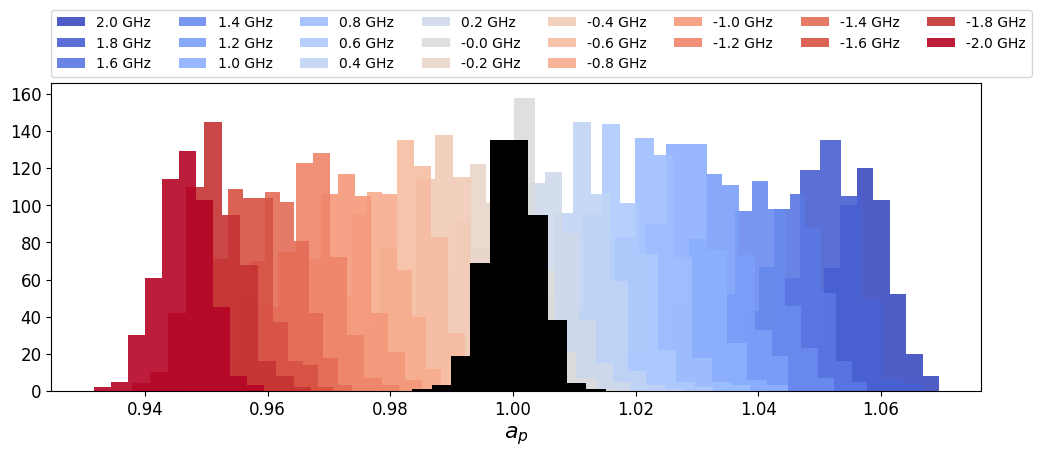

In [ ]:
%matplotlib inline
from matplotlib.cm import get_cmap
cmap = get_cmap('coolwarm')  # Red to blue gradient
n = len(freqs)
plt.figure(figsize = (12,4))
means = []
for i, freq in enumerate(freqs):
    fits = generate_fits_center(spectra_bin[2][1],err[2,1], cib_bins[i])
    mu, sigma = np.mean(fits), np.std(fits)
    means.append(mu)

    offset = 850 - freq
    label = f'{offset:.1f} GHz' # (μ={mu:.1f}' #, σ={sigma:.1f})'
    color = cmap(i / (n - 1))
    plt.hist(fits,  alpha=0.9, label=label, color = color)

plt.hist(generate_fits_center(spectra_bin[2][1],err[2,1], spectra_bin[2][1]), color = 'black')

#plt.title('Mean $a_c$ vs Band Center (around 280 GHz)', fontsize=16)
plt.xlabel('$a_p$',fontsize=16)
#plt.ylabel('$a_c$',fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.legend(bbox_to_anchor=(0, 1.02, 1, 0.2), loc="lower left", borderaxespad=0, ncol=8)
#plt.tight_layout()
plt.gca().set_facecolor('white')
#plt.savefig('./cib_280GHz_fit_no_shift_240402.png', bbox_inches='tight', facecolor='white',dpi=200) 

In [ ]:
%matplotlib inline
from matplotlib.cm import get_cmap
cmap = get_cmap('coolwarm')  # Red to blue gradient
n = len(freqs)
plt.figure(figsize = (12,4))
means = []
for i, freq in enumerate(freqs):
    fits = generate_fits_center(spectra_bin[2][1],err[2,1], cib_bins[i])
    mu, sigma = np.mean(fits), np.std(fits)
    means.append(mu)

    offset = 850 - freq
    label = f'{offset:.1f} GHz' # (μ={mu:.1f}' #, σ={sigma:.1f})'
    color = cmap(i / (n - 1))
    plt.hist(fits,  alpha=0.9, label=label, color = color)

plt.hist(generate_fits_center(spectra_bin[2][1],err[2,1], spectra_bin[2][1]), color = 'black')

#plt.title('Mean $a_c$ vs Band Center (around 280 GHz)', fontsize=16)
plt.xlabel('$a_p$',fontsize=16)
#plt.ylabel('$a_c$',fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.legend(bbox_to_anchor=(0, 1.02, 1, 0.2), loc="lower left", borderaxespad=0, ncol=8)
#plt.tight_layout()
plt.gca().set_facecolor('white')
#plt.savefig('./cib_280GHz_fit_no_shift_240402.png', bbox_inches='tight', facecolor='white',dpi=200) 

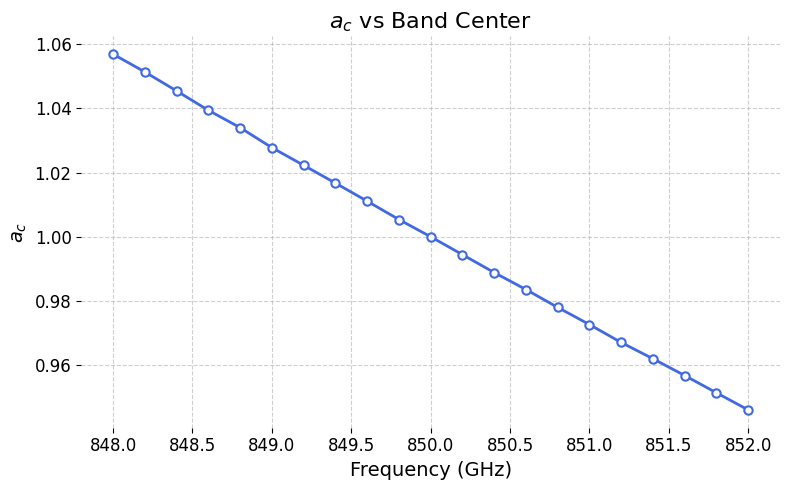

In [ ]:
%matplotlib inline
plt.figure(figsize=(8, 5))

# Plot with smooth line and markers
plt.plot(freqs, means, '-o', color='royalblue', linewidth=2, markersize=6, markerfacecolor='white', markeredgewidth=1.5)

# Grid and axis styling
plt.grid(True, linestyle='--', alpha=0.6)
plt.xlabel('Frequency (GHz)', fontsize=14)
plt.ylabel('$a_c$', fontsize=14)
plt.title('$a_c$ vs Band Center', fontsize=16)

# Ticks and layout
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

# Background and spines
ax = plt.gca()
ax.set_facecolor('white')
for spine in ax.spines.values():
    spine.set_visible(False)

# Optional: Save
# plt.savefig('ac_vs_freq.png', dpi=300, bbox_inches='tight', facecolor='white')

plt.show()

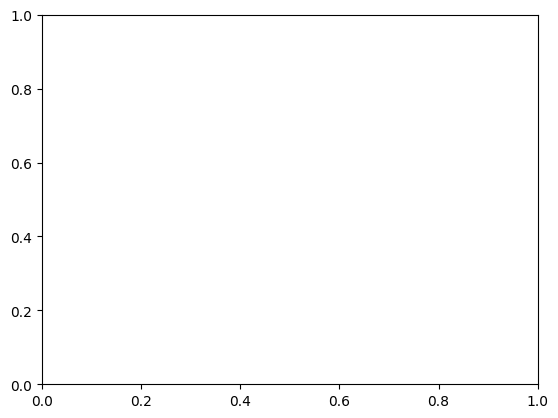

In [ ]:
from matplotlib.animation import FuncAnimation, PillowWriter

fig, ax = plt.subplots()

def animate(j):
    plt.cla()
    plt.clf()
    #plt.close()
    for i in range(len(np.array(specs))):
        plt.plot(ells, specs[i][j, j], lw=2, label='%s'%lab[i])
    
    plt.plot(ells, np.sum([s[j, j] for s in specs], axis=0), label="fg sum", linestyle='--')

    plt.legend(loc = 'lower right')
    plt.yscale('log')
    plt.title('%.1f GHz'%freqs[j])
    plt.axhline(y=1e-1,alpha=0.5,color='k')
    #plt.show()
    #print(f"loaded plot {j}")
    return()
#ani = FuncAnimation(fig, animate, repeat=True, frames=len(freqs), interval=50)
# To save the animation using Pillow as a gif
#writer = PillowWriter(fps=4,metadata=dict(artist='Me'),bitrate=1800)
#ani.save('test.gif', writer=writer)